In [1]:
### Author: Yutian Zhao

In [2]:
from IPython.display import HTML
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

<h1> Performance</h1>

In [1]:
import sys, os, platform, pickle, json, time
from datetime import datetime, timedelta
import numpy as np
from collections import Counter, defaultdict
import networkx as nx
from tqdm import tqdm
import math
import scipy as sp
import scipy.stats
from collections import defaultdict 
from scipy.stats import spearmanr

from utils.data_loader import DataLoader
from utils.plot import ColorPalette, concise_fmt, hide_spines, stackedBarPlot
from utils.helper import Timer, is_same_genre
data_prefix = 'data/' # ../

# from powerlaw import Fit, plot_ccdf

import matplotlib as mpl
if platform.system() == 'Linux':
    mpl.use('Agg')  # no UI backend

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
mpl.rcParams['lines.linewidth'] = 1

T = 63

In [23]:
### contrust network graph for each day
if not os.path.exists(os.path.join(data_prefix, "video_network.pkl")):
    graph_lst = []
    for i in edges:
        G = nx.DiGraph()
        G.add_edges_from(i)
        graph_lst.append(G)
        
    with open(os.path.join(data_prefix, "video_network.pkl"), 'wb') as fout:
        pickle.dump(graph_lst, fout)
else:
    with open(os.path.join(data_prefix, "video_network.pkl"), 'rb') as fin:
        graph_lst = pickle.load(fin)

In [4]:
data_loader = DataLoader()
data_loader.load_embed_content_dict()
# data_loader.cwd
embed_view_dict = data_loader.embed_view_dict
embed_avg_view_dict = data_loader.embed_avg_view_dict
num_videos = data_loader.num_videos
embed_title_dict = data_loader.embed_title_dict
embed_cid_dict = data_loader.embed_cid_dict
embed_genre_dict = data_loader.embed_genre_dict
embed_uploadtime_dict = data_loader.embed_uploadtime_dict
for embed in range(num_videos):
    upload_year = int(embed_uploadtime_dict[embed][:4])
    if upload_year >= 2009:
        year_idx = upload_year - 2009
    else:
        year_idx = 0
    embed_uploadtime_dict[embed] = year_idx

>>> Daily view data has been loaded!


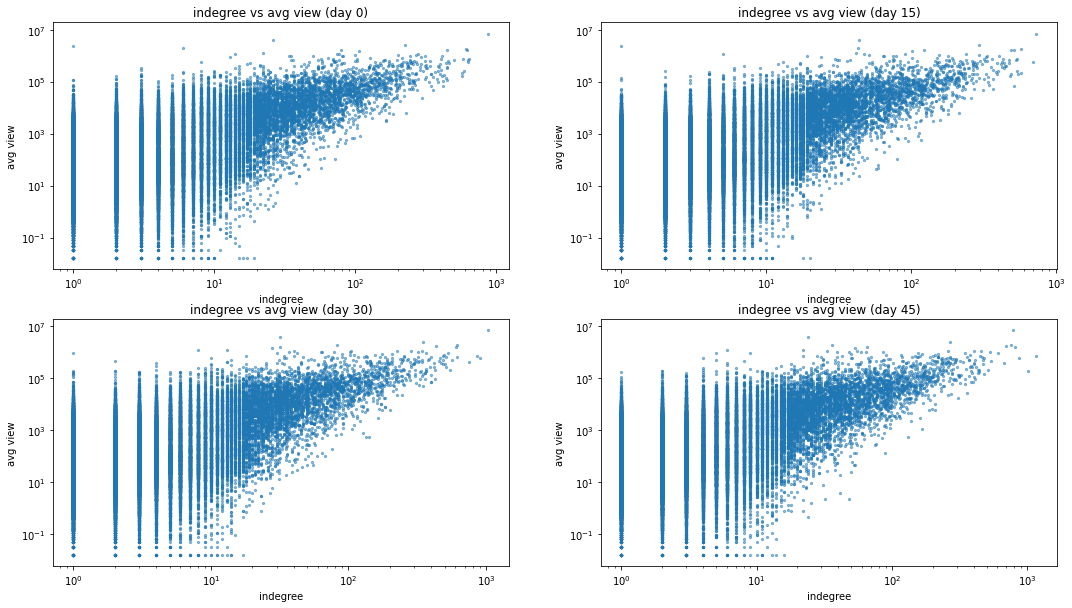

In [6]:
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    ind_list = []
    avg_view = []
    for v in graph_lst[c].nodes():
        avg_view.append(embed_avg_view_dict[v])
        ind_list.append(graph_lst[c].in_degree(v))
    plt.scatter(ind_list, avg_view, s=5, marker='o', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("indegree vs avg view (day {0})".format((c)))
    plt.xlabel("indegree")
    plt.ylabel("avg view")

[0.0, 0.0, 4.0867041881593135e-218, 1.2613588906038688e-240, 3.55771071091311e-185, 1.450625923292077e-282, 5.018088450991729e-202, 1.0917427031358834e-175, 3.064164814704793e-165, 2.6913730630141424e-97, 1.1091842348251527e-67]
[0.0, 0.0, 4.426563950131315e-241, 6.237777402721542e-266, 4.6679888159840126e-209, 0.0, 6.3697864146925345e-236, 8.602153996654318e-207, 2.333227838570869e-176, 4.49753161010153e-122, 1.937727929424391e-75]
[0.0, 0.0, 1.3607352371434156e-194, 6.122404322084495e-228, 2.0964658414668465e-185, 1.954053921066807e-271, 4.831265284385516e-196, 1.231514261847999e-163, 2.3931683536947223e-158, 5.624200796403897e-105, 7.078817931293726e-70]
[0.0, 0.0, 2.927608767398075e-222, 4.844895817250076e-236, 9.372322356158134e-183, 1.1606014103810218e-280, 9.521759916978532e-197, 7.64841346939947e-161, 3.678232984112775e-149, 1.160852727509025e-102, 9.480081525182669e-53]


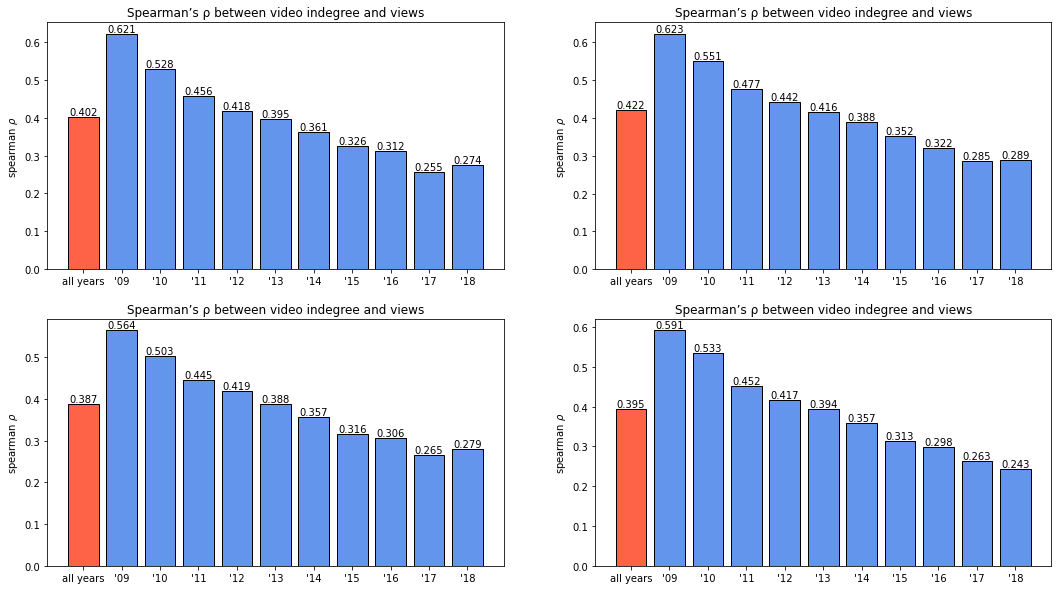

In [8]:

year_labels = ["all years", "'09", "'10", "'11", "'12", "'13", "'14", "'15", "'16", "'17", "'18"]
num_year = len(year_labels) - 1




plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    all_indegrees = []
    all_views = []
    views_by_years_list = [[] for _ in range(num_year)]
    indegrees_by_years_list = [[] for _ in range(num_year)]
    
    for v in graph_lst[c].nodes():
        ind = graph_lst[c].in_degree(v)
        all_views.append(embed_avg_view_dict[v])
        all_indegrees.append(ind)
        views_by_years_list[embed_uploadtime_dict[v]].append(embed_avg_view_dict[v])
        indegrees_by_years_list[embed_uploadtime_dict[v]].append(ind)
    
    spearman_traces = []
    p_traces = []
    s, p = spearmanr(all_views, all_indegrees)
    spearman_traces.append(s)
    p_traces.append(p)
    for i in range(num_year):
        s, p = spearmanr(views_by_years_list[i], indegrees_by_years_list[i])
        spearman_traces.append(s)
        p_traces.append(p)
    print(p_traces)
    
#     fig, ax1 = plt.subplots(2,2,i+1)
    tomato = ColorPalette.TOMATO
    blue = ColorPalette.BLUE

    bar1 = plt.bar(range(num_year + 1), spearman_traces, edgecolor=['k'] * (num_year + 1),
                   color=[tomato] + [blue] * num_year, lw=1)
    for rect in bar1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, '{0:.3f}'.format(height), ha='center', va='bottom')

    plt.xticks(np.arange(11), labels=year_labels)
    plt.ylabel(r'spearman $\rho$')
    plt.title("Spearman’s ρ between video indegree and views")

#     hide_spines(ax1)

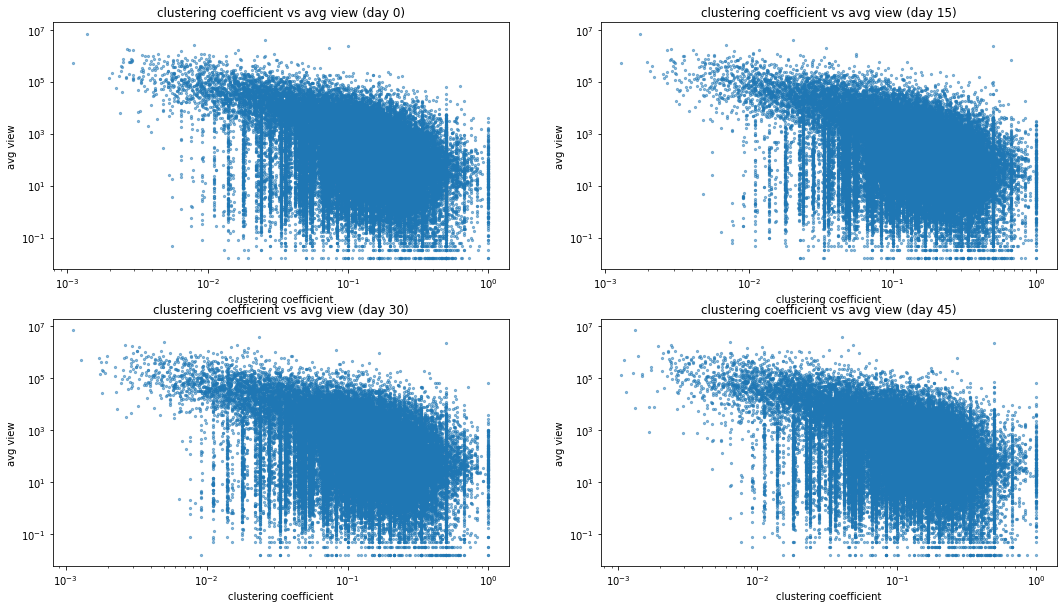

In [9]:
## Clustering coefficient What portion of i’s neighbors are connected
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    cc_list = []
    avg_view = []
    for v, cc in nx.clustering(graph_lst[c]).items():
        avg_view.append(embed_avg_view_dict[v])
        cc_list.append(cc)
    plt.scatter(cc_list, avg_view, s=5, marker='o', alpha=0.5)
    plt.xscale('log')
    plt.yscale('log')
    plt.title("clustering coefficient vs avg view (day {0})".format((c)))
    plt.xlabel("clustering coefficient")
    plt.ylabel("avg view")

[0.0, 1.8950649935800524e-187, 7.660619695605386e-31, 5.286180489178186e-15, 0.12029203481796562, 1.3158508855389448e-23, 7.724986490372096e-33, 1.3775928184442634e-89, 5.918371123028708e-41, 8.792730802790104e-88, 7.112374385217634e-51]
[0.0, 1.1352928036221715e-188, 3.0981821375465196e-28, 8.13040530878758e-14, 0.010010950275689852, 3.9749516233213725e-24, 5.613102100722292e-31, 2.7725779755155234e-86, 4.122337004748777e-52, 1.1627352049578129e-98, 4.298268728258287e-52]
[0.0, 9.938896412103533e-139, 6.0340474499796414e-12, 3.2948411157760875e-07, 0.7492444490514567, 9.34221011656958e-13, 1.6321726982700462e-18, 2.5272387471121867e-64, 1.061810114794838e-28, 7.877761189138757e-72, 1.3660334022716858e-54]
[1.8474979688968207e-166, 2.367454867900278e-94, 4.012671035617718e-06, 0.3734760943630545, 7.109662608684428e-06, 0.00012071888357076894, 1.2032309945720464e-05, 3.47751151922736e-32, 1.6635181484704214e-35, 1.1200145753514312e-79, 2.1183623582830536e-27]


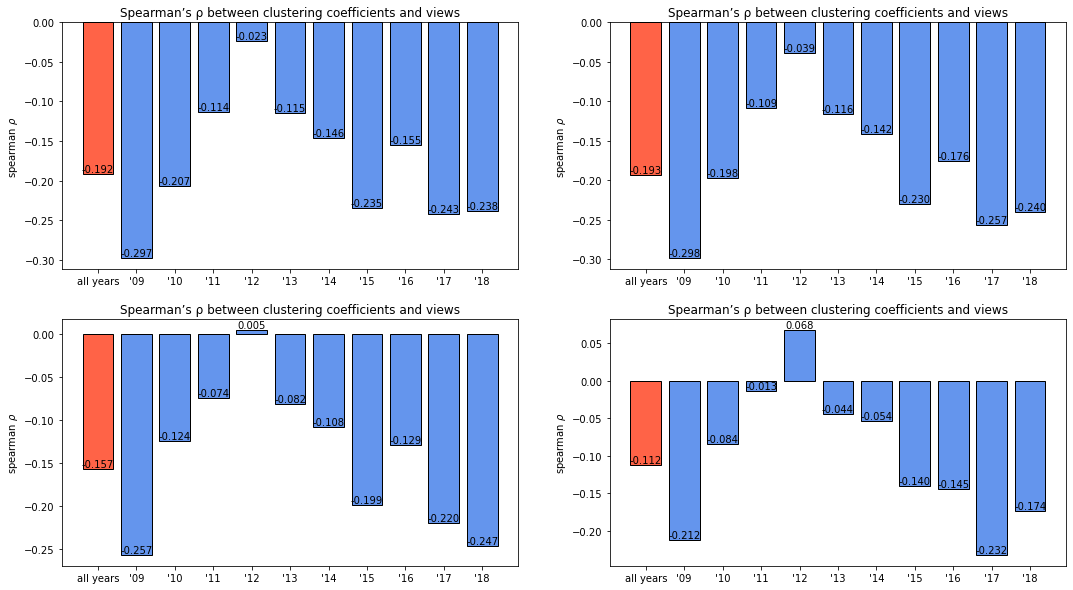

In [10]:
plt.figure(figsize=(18,10))
candidates = [0, 15, 30, 45]
for i, c in enumerate(candidates):
    plt.subplot(2,2,i+1)
    cc_list = []
    all_views = []
    views_by_years_list = [[] for _ in range(num_year)]
    cc_by_years_list = [[] for _ in range(num_year)]
    for v, cc in nx.clustering(graph_lst[c]).items():
        all_views.append(embed_avg_view_dict[v])
        cc_list.append(cc)
        views_by_years_list[embed_uploadtime_dict[v]].append(embed_avg_view_dict[v])
        cc_by_years_list[embed_uploadtime_dict[v]].append(cc)

    spearman_traces = []
    p_traces = []
    s, p = spearmanr(all_views, cc_list)
    spearman_traces.append(s)
    p_traces.append(p)
    for i in range(num_year):
        s, p = spearmanr(views_by_years_list[i], cc_by_years_list[i])
        spearman_traces.append(s)
        p_traces.append(p)
    print(p_traces)

#     fig, ax1 = plt.subplots(2,2,i+1)
    tomato = ColorPalette.TOMATO
    blue = ColorPalette.BLUE

    bar1 = plt.bar(range(num_year + 1), spearman_traces, edgecolor=['k'] * (num_year + 1),
                   color=[tomato] + [blue] * num_year, lw=1)
    for rect in bar1:
        height = rect.get_height()
        plt.text(rect.get_x() + rect.get_width() / 2.0, height, '{0:.3f}'.format(height), ha='center', va='bottom')

    plt.xticks(np.arange(11), labels=year_labels)
    plt.ylabel(r'spearman $\rho$')
    plt.title("Spearman’s ρ between clustering coefficients and views")
#     hide_spines(ax1)

In [1]:
arnet_weights = dict()
with open(os.path.join('models', 'forecast_tracker_all.json'), 'r') as fin:
    for line in fin:
        result_json = json.loads(line.rstrip())
        tar_embed = result_json['embed']
        src_embed = result_json['incoming_embeds']
        link_weights = result_json['link_weights']
        for i, s in enumerate(src_embed):
            arnet_weights[(s, tar_embed)] = link_weights[i]
            

NameError: name 'os' is not defined

In [5]:
persistent_graph = nx.DiGraph()
min_weight = math.inf  # -4.3145126696113597e-13
max_weight = -math.inf  # 779334.1781090087
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        edge_weight = arnet_weights[(src_embed, tar_embed)]*embed_avg_view_dict[src_embed]
        persistent_graph.add_edge(src_embed, tar_embed, weight=edge_weight)
        if edge_weight > max_weight:
            max_weight = edge_weight
        elif edge_weight < min_weight:
            min_weight = edge_weight

In [6]:
persistent_nodes=set(persistent_graph.nodes)

In [7]:
len(persistent_nodes)

31261

In [38]:
radflow_nodes = set()
radflow_edges = set()
with open(os.path.join(data_prefix, 'vevo_attention_scores.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        tar, src, score = line.split(",")
        scores = [float(i) for i in score.split(";")]
        radflow_nodes.add(int(tar))
        radflow_nodes.add(int(src))
        if np.sum(np.array(scores)) != 0:
            radflow_edges.add((int(src), int(tar)))
print("num_edges: ", len(radflow_edges))
print("num_nodes: ", len(radflow_nodes))

num_edges:  516792
num_nodes:  60501


In [44]:
edges_not_found = []
for s, t in radflow_edges:
    flag = False
    for g in graph_lst:
        
        if g.has_edge(s, t) or g.has_edge(t, s):
            flag = True
            break
    if not flag:
        edges_not_found.append((s, t))
#         print(e)
#         break
        

In [47]:
len(edges_not_found)

148044

In [40]:
for g in graph_lst:
    if g.has_edge(22090, 16600):
        print("has")

has
has
has
has
has
has
has
has
has
has
has
has
has
has


In [45]:
len(graph_lst)

63

In [17]:
print(sorted(list(embed_view_dict.keys()), reverse=True))

[60739, 60738, 60737, 60736, 60735, 60734, 60733, 60732, 60731, 60730, 60729, 60728, 60727, 60726, 60725, 60724, 60723, 60722, 60721, 60720, 60719, 60718, 60717, 60716, 60715, 60714, 60713, 60712, 60711, 60710, 60709, 60708, 60707, 60706, 60705, 60704, 60703, 60702, 60701, 60700, 60699, 60698, 60697, 60696, 60695, 60694, 60693, 60692, 60691, 60690, 60689, 60688, 60687, 60686, 60685, 60684, 60683, 60682, 60681, 60680, 60679, 60678, 60677, 60676, 60675, 60674, 60673, 60672, 60671, 60670, 60669, 60668, 60667, 60666, 60665, 60664, 60663, 60662, 60661, 60660, 60659, 60658, 60657, 60656, 60655, 60654, 60653, 60652, 60651, 60650, 60649, 60648, 60647, 60646, 60645, 60644, 60643, 60642, 60641, 60640, 60639, 60638, 60637, 60636, 60635, 60634, 60633, 60632, 60631, 60630, 60629, 60628, 60627, 60626, 60625, 60624, 60623, 60622, 60621, 60620, 60619, 60618, 60617, 60616, 60615, 60614, 60613, 60612, 60611, 60610, 60609, 60608, 60607, 60606, 60605, 60604, 60603, 60602, 60601, 60600, 60599, 60598, 60597

In [22]:
persistent_graph.has_edge(14856, 1)

True

In [12]:
a = "0,58728,0.0;0.0;0.0;0.0;0.0;0.0;0.0"
b = a.split(",")
c = b[2].split(";")
c

['0.0', '0.0', '0.0', '0.0', '0.0', '0.0', '0.0']

In [9]:
ts = 0
ss = 0
for i in persistent_graph.nodes():
    if persistent_graph.in_degree(i) > 0:
        ts += 1
    if persistent_graph.out_degree(i) > 0:
        ss += 1
print(ts)
print(ss)

13710
28657


Text(0, 0.5, 'avg view')

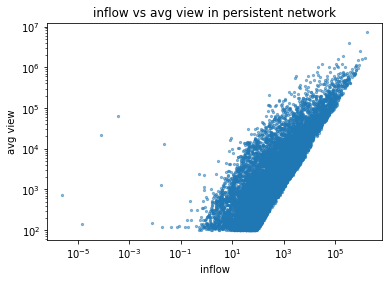

In [14]:
inflow_list = []
avg_view = []
for v in persistent_graph.nodes():
    if persistent_graph.in_degree(v) > 0:
        avg_view.append(embed_avg_view_dict[v])
        inflow = 0
        for src in persistent_graph.predecessors(v):
            inflow += persistent_graph[src][v]['weight']
        inflow_list.append(inflow)
plt.scatter(inflow_list, avg_view, s=5, marker='o', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.title("inflow vs avg view in persistent network")
plt.xlabel("inflow")
plt.ylabel("avg view")

<ipython-input-15-c1e63d426fbd>:12: RuntimeWarning: divide by zero encountered in double_scalars
  flow_ratio_list.append(outflow/inflow)
<ipython-input-15-c1e63d426fbd>:12: RuntimeWarning: invalid value encountered in double_scalars
  flow_ratio_list.append(outflow/inflow)


Text(0, 0.5, 'avg view')

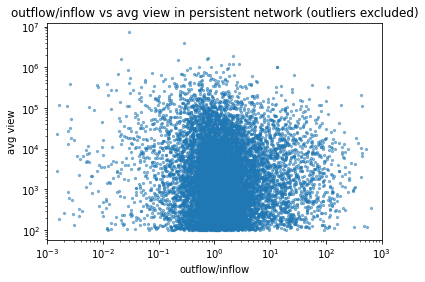

In [15]:
flow_ratio_list = []
avg_view = []
for v in persistent_graph.nodes():
    if persistent_graph.in_degree(v) > 0:
        avg_view.append(embed_avg_view_dict[v])
        inflow = 0
        outflow = 0
        for src in persistent_graph.predecessors(v):
            inflow += persistent_graph[src][v]['weight']
        for tar in persistent_graph.successors(v):
            outflow += persistent_graph[v][tar]['weight']
        flow_ratio_list.append(outflow/inflow)
plt.scatter(flow_ratio_list, avg_view, s=5, marker='o', alpha=0.5)
plt.xscale('log')
plt.yscale('log')
plt.xlim((0.001,1000))
plt.title("outflow/inflow vs avg view in persistent network (outliers excluded)")
plt.xlabel("outflow/inflow")
plt.ylabel("avg view")

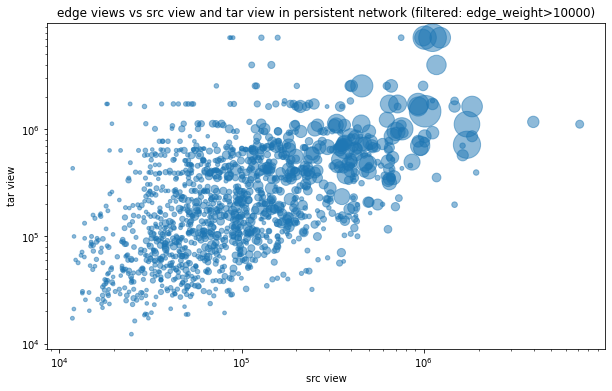

In [16]:
plt.figure(figsize=(10, 6))
src_list = []
tar_list = []
weight_list = []
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        edge_weight = persistent_graph[src_embed][tar_embed]['weight']
        if edge_weight>10000:
            src_list.append(embed_avg_view_dict[src_embed])
            tar_list.append(embed_avg_view_dict[tar_embed])
            weight_list.append(1000*(edge_weight-min_weight)/(max_weight-min_weight))
    plt.scatter(src_list, tar_list, s=weight_list, marker='o', alpha=0.5)
    plt.title("edge views vs src view and tar view in persistent network (filtered: edge_weight>10000)")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("src view")
    plt.ylabel("tar view")

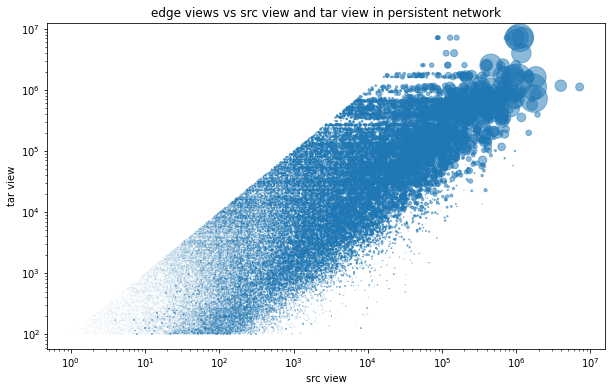

In [17]:
plt.figure(figsize=(10, 6))
src_list = []
tar_list = []
weight_list = []
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        src_list.append(embed_avg_view_dict[src_embed])
        tar_list.append(embed_avg_view_dict[tar_embed])
        edge_weight = persistent_graph[src_embed][tar_embed]['weight']
        weight_list.append(1000*(edge_weight-min_weight)/(max_weight-min_weight)) # better squash function
    plt.scatter(src_list, tar_list, s=weight_list, marker='o', alpha=0.5)
    plt.title("edge views vs src view and tar view in persistent network")
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel("src view")
    plt.ylabel("tar view")

Text(0.5, 1.0, 'link diversity vs edge weight in persistent network (outlier excluded)')

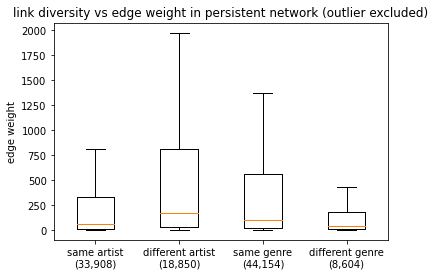

In [18]:
same_artist_view_list = []
diff_artist_view_list = []
same_genre_view_list = []
diff_genre_view_list = []
with open(os.path.join(data_prefix, 'persistent_network.csv'), 'r') as fin:
    fin.readline()
    for line in fin:
        src_embed, tar_embed = map(int, line.rstrip().split(','))
        if embed_cid_dict[src_embed] == embed_cid_dict[tar_embed]:
            same_artist_view_list.append(persistent_graph[src_embed][tar_embed]['weight'])
        else:
            diff_artist_view_list.append(persistent_graph[src_embed][tar_embed]['weight'])
            
        if is_same_genre(embed_genre_dict[src_embed], embed_genre_dict[tar_embed]):
            same_genre_view_list.append(persistent_graph[src_embed][tar_embed]['weight'])
        else:
            diff_genre_view_list.append(persistent_graph[src_embed][tar_embed]['weight'])

xlabels=['same artist' + '\n({0:,})'.format(len(same_artist_view_list)),
        'different artist' + '\n({0:,})'.format(len(diff_artist_view_list)),
        'same genre' + '\n({0:,})'.format(len(same_genre_view_list)),
        'different genre' + '\n({0:,})'.format(len(diff_genre_view_list))]
plt.boxplot([same_artist_view_list, diff_artist_view_list, same_genre_view_list, diff_genre_view_list], labels=xlabels, showfliers=False)
plt.ylabel('edge weight')
plt.title("link diversity vs edge weight in persistent network (outlier excluded)")

In [ ]:
## 
